In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
import numpy as np

BATCH_SIZE = 50
EPOCHS = 300
SEED = 2

In [3]:
def read_data(filename):
    labels, sentences1, sentences2 = [], [], []
    with open(filename) as f:
        for line in f:
            split_list = line.split(",")
            t = int(split_list[2])
            labels.append(t)
            sentences1.append(split_list[0])
            sentences2.append(split_list[1])
    return labels, sentences1, sentences2

all_labels, all_sentences1, all_sentences2 = read_data('MC1.TXT')
all_data = list(zip(all_sentences1[0:80], all_sentences2[0:80]))

train_labels, train_data1, train_data2 = all_labels[0: 80], all_sentences1[0: 80], all_sentences2[0: 80]
test_labels, test_data1, test_data2 = all_labels[80: 100], all_sentences1[80: 100], all_sentences2[80: 100]
test_data =  list(zip(all_sentences1[80:100], all_sentences2[80:100]))


In [4]:
from lambeq import BobcatParser

parser = BobcatParser(verbose='text')

raw_train_sentences1_diagrams = parser.sentences2diagrams(train_data1)
raw_test_sentences1_diagrams = parser.sentences2diagrams(test_data1)
raw_train_sentences2_diagrams = parser.sentences2diagrams(train_data2)
raw_test_sentences2_diagrams = parser.sentences2diagrams(test_data2)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


In [5]:
from lambeq import remove_cups

train_s1_diagrams = [remove_cups(diagram) for diagram in raw_train_sentences1_diagrams]

test_s1_diagrams = [remove_cups(diagram) for diagram in raw_test_sentences1_diagrams]

train_s2_diagrams = [remove_cups(diagram) for diagram in raw_train_sentences2_diagrams]

test_s2_diagrams = [remove_cups(diagram) for diagram in raw_test_sentences2_diagrams]

In [6]:
from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

train_s1_circuits = [ansatz(diagram) for diagram in train_s1_diagrams]

test_s1_circuits = [ansatz(diagram) for diagram in test_s1_diagrams]

train_s2_circuits = [ansatz(diagram) for diagram in train_s2_diagrams]

test_s2_circuits = [ansatz(diagram) for diagram in test_s2_diagrams]

train_circuits = train_s1_circuits + train_s2_circuits
test_circuits =  test_s1_circuits + test_s2_circuits
all_circuits_lst = train_circuits + test_circuits
all_train_data = list(zip((list(zip(train_s1_circuits, train_s2_circuits))), train_labels))
all_test_data =  list(zip(list(zip(test_s1_circuits, test_s2_circuits)), test_labels))


In [7]:
from pytket.circuit.display import render_circuit_jupyter

tket_circuit = train_circuits[17].to_tk()

render_circuit_jupyter(tket_circuit)

In [8]:
from lambeq import NumpyModel, Model
def cos_sim_2d(x, y):
        norm_x = x / np.linalg.norm(x, axis=1, keepdims=True)
        norm_y = y / np.linalg.norm(y, axis=1, keepdims=True)
        return np.matmul(norm_x, norm_y.T)
    
class ClassificationModel(NumpyModel): 
    
    def forward(self, Mytuple):
        a = np.array(Mytuple)
        y_hat = []
        output1 = NumpyModel.get_diagram_output(self, diagrams=a[:, 0])
        output2 = NumpyModel.get_diagram_output(self, diagrams=a[:, 1])
        
        #reshaped_o2 = output2.transpose()
        similarity_matrix = cos_sim_2d(output1, output2)
        for idx in range(0, len(similarity_matrix)):
            row_idx = np.argmax(similarity_matrix[idx, :])
            if row_idx == idx:
                y_hat.append(1)
            else :
                y_hat.append(0)
        return np.array(y_hat)


In [9]:

#Model.initialize_weights()
train_circuits2 = list(zip(train_s1_circuits , train_s2_circuits))

test_circuits2 = list(zip(test_s1_circuits , test_s2_circuits))
all_circuits = train_circuits2 + test_circuits2
sentence1_circuits= [ seq[0] for seq in all_circuits]
sentence2_circuits= [ seq[1] for seq in all_circuits]
all_circuits_lst = sentence1_circuits + sentence2_circuits

model = ClassificationModel.from_diagrams(all_circuits_lst, use_jit=True)


In [10]:
import numpy
epsilon=numpy.finfo('float').eps
loss = lambda y_hat, y: -np.sum(y * np.log(y_hat + epsilon)) / len(y)  # binary cross-entropy lossةخيثم
acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting

In [11]:
from lambeq import QuantumTrainer, SPSAOptimizer

trainer = QuantumTrainer(
    model,
    epochs=EPOCHS,
    loss_function=loss,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)

In [12]:
from lambeq import Dataset

train_dataset = Dataset(
            train_circuits2,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(test_circuits2, test_labels, shuffle=False)


In [13]:
trainer.fit(train_dataset, val_dataset, logging_step=12)

Epoch 1:    train/loss: 18.6976   valid/loss: 16.2196   train/acc: 0.2313   valid/acc: 0.2750
Epoch 12:   train/loss: 19.3735   valid/loss: 12.6153   train/acc: 0.2313   valid/acc: 0.3250
Epoch 24:   train/loss: 18.9229   valid/loss: 14.4175   train/acc: 0.2313   valid/acc: 0.3000
Epoch 36:   train/loss: 18.9229   valid/loss: 14.4175   train/acc: 0.2313   valid/acc: 0.3000
Epoch 48:   train/loss: 18.6976   valid/loss: 12.6153   train/acc: 0.2313   valid/acc: 0.3000
Epoch 60:   train/loss: 19.1482   valid/loss: 16.2196   train/acc: 0.2313   valid/acc: 0.2750
Epoch 72:   train/loss: 18.6976   valid/loss: 14.4175   train/acc: 0.2375   valid/acc: 0.2750
Epoch 84:   train/loss: 18.6976   valid/loss: 16.2196   train/acc: 0.2375   valid/acc: 0.2500
Epoch 96:   train/loss: 19.3735   valid/loss: 14.4175   train/acc: 0.2313   valid/acc: 0.3000
Epoch 108:  train/loss: 18.4724   valid/loss: 14.4175   train/acc: 0.2313   valid/acc: 0.3000
Epoch 120:  train/loss: 18.6976   valid/loss: 12.6153   trai

Test accuracy: 0.275


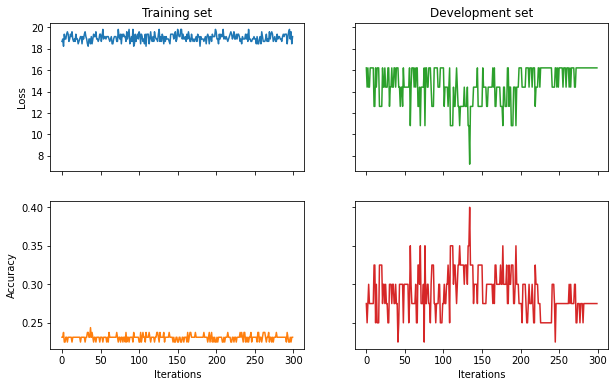

In [14]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(trainer.train_results['acc'], color=next(colours))
ax_tr.plot(trainer.val_costs, color=next(colours))
ax_br.plot(trainer.val_results['acc'], color=next(colours))

test_acc = acc(model(test_circuits2), test_labels)
print('Test accuracy:', test_acc)